In [1]:
import pandas as pd
import numpy as np
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf
from keras import backend
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
import matplotlib.pyplot as plt

from IPython.display import clear_output

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-01 21:13:57.999322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataConversion:
    def __init__(self, limit, low=0.0, high=1.0):
        self.limit = limit
        if low>high:
            low, high = high, low
        self.low = low
        self.high = high
        print(low, high)
        
        
    def __getNewValue__(self, x, newMin, newMax, oldMin, oldMax):
        return newMin+(((x-oldMin)*(newMax-newMin))/(oldMax-oldMin))
        
    def convertToNewRange(self, X):
        X_new = X.copy()
        X_new = X_new.astype(np.float32)

        for d in range(np.size(X_new, 1)):
            minf, maxf = self.limit[d][0], self.limit[d][1]
            X_new[:, d] = [self.__getNewValue__(x, self.low, self.high, minf, maxf) for x in X_new[:, d]]

        return X_new 
    
    def revertToOriginalValue(self, X):
        X_new = X.copy()
        X_new = X_new.astype(np.float32)

        for d in range(np.size(X_new, 1)):
            minf, maxf = self.limit[d][0], self.limit[d][1]
            X_new[:, d] = [self.__getNewValue__(x, minf, maxf, self.low, self.high) for x in X_new[:, d]]

        return X_new

In [3]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clipValue):
        self.clip_value = np.absolute(clipValue)
        
    # clip model weights to hypercube
    def __call__(self, weight):
        return backend.clip(weight, -self.clip_value, self.clip_value)
    
    # get the clip value
    def getConfig(self):
        return self.clip_value
    
# Compute wasserstein loss
def wasserstein_loss(y_real, y_pred):
    return backend.mean(y_real*y_pred)

class GAN_model:
    def __init__(self, latent_dim, data_dim, init = tf.keras.initializers.glorot_normal(), const=tf.keras.constraints.min_max_norm(), opt=tf.keras.optimizers.Adam()):
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.init = init
        self.const = const
        self.opt = opt
        self.d_model = self.__discreminator__()
        self.g_model = self.__generator__()
        self.gan_model = self.__GAN__()
        
    # Define discreminator model
    def __discreminator__(self):
        # Create descrimincator model
        model = Sequential()
        model.add(Dense(25, kernel_initializer=self.init, kernel_constraint=self.const, input_dim=self.data_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.compile(loss=wasserstein_loss, optimizer = self.opt)
        return model

    # Define generator model
    def __generator__(self):
        model = Sequential()
        model.add(Dense(self.latent_dim*3, kernel_initializer=self.init, kernel_constraint=self.const, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.data_dim, activation='tanh'))
        return model
    
    # define GAN model
    def __GAN__(self):
        #for layer in self.d_model.layers:
        #    if not isinstance(layer, BatchNormalization):
        #        
        
        self.d_model.trainable=False
        model = Sequential()
        model.add(self.g_model)
        model.add(self.d_model)
        model.compile(loss=wasserstein_loss, optimizer = self.opt)
        return model

In [4]:
class DataProcessing:
    def __init__(self, data, latent_dim, image_path='./', model_path='./', kernel_init=tf.keras.initializers.glorot_normal(), kernel_const=tf.keras.constraints.min_max_norm(), optimizer=tf.keras.optimizers.Adam(), dataConversion=(0,1)):
        self.latent_dim = latent_dim
        self.data = data
        if isinstance(self.data, pd.DataFrame):
            self.data = self.data.to_numpy()
            
        self.data = self.data.astype(np.float32)
        self.limit = self.__get_limit__(self.data)
        self.sample_size = np.size(self.data, 0)
        self.image_path = image_path
        self.model_path = model_path
        self.dc = DataConversion(self.limit, low=dataConversion[0], high=dataConversion[1])
        self.gan_model = GAN_model(self.latent_dim, np.size(self.data, 1), kernel_init, kernel_const, optimizer)
        
    def __get_limit__(self, X):
        limit = []
        for d in range(np.size(X, 1)):
            limit.append((min(X[:, d]), max(X[:, d])))
        print('Data limit=',limit)
        return limit
        
    # Generate real sample with target label= -1
    def __get_real_data__(self):
        X = self.dc.convertToNewRange(self.data)
        y = -ones((self.sample_size, 1))
        return X,y
    
    def __get_latent_data__(self, nrows):
        #X = randn(latent_dim*nrows)
        #X = X.reshape(nrows, latent_dim)

        X = np.empty([nrows, self.latent_dim])

        # For each column, generate random value with in a limit
        for j in range(self.latent_dim):
            X[:, j] = randn(nrows)

        # Convert the data to float32
        X = X.astype(np.float32)
        
        return X

    # Generate latent data with latent dimension
    def __generate_latent_data__(self, nrows=0):
        if nrows ==0:
            nrows = self.sample_size

        return self.__get_latent_data__(nrows)

    # Generate fake data using latent data
    def __generate_fake_sample__(self):
        X_latent = self.__generate_latent_data__()
        X_fake = self.gan_model.g_model.predict(X_latent, verbose=0)
        y = ones((self.sample_size, 1))
        return X_fake, y
    
    def __summarize_performance__(self, epoch):
        X_real, y_real = self.__get_real_data__()
        real_perf = self.gan_model.d_model.evaluate(X_real, y_real, verbose=0, return_dict=True, use_multiprocessing=True)

        X_fake, y_fake = self.__generate_fake_sample__()
        fake_perf = self.gan_model.d_model.evaluate(X_fake, y_fake, verbose=0, return_dict=True, use_multiprocessing=True)


        self.gan_model.g_model.save(f'{self.model_path}WGAN_generator_{epoch}.h5')
        self.gan_model.d_model.save(f'{self.model_path}WGAN_descriminator_{epoch}.h5')
        print('Descriminator performance on:')
        print('\t Real data=',real_perf)
        print('\t Fake data=',fake_perf)
        
        print()
        print('Before conversion to real range:')
        print('Real data limit=',self.__get_limit__(X_real))
        print('Fake data limit=',self.__get_limit__(X_fake))
        
        X_real = self.dc.revertToOriginalValue(X_real)
        X_fake = self.dc.revertToOriginalValue(X_fake)
        
        print()
        print('After conversion to real range:')
        print('Real data limit=',self.__get_limit__(X_real))
        print('Fake data limit=',self.__get_limit__(X_fake))

        plt.figure(figsize=(7,5), dpi=200)
        plt.scatter(X_real[:, 0], X_real[:, 1], color='red', label='Real data')
        plt.scatter(X_fake[:, 0], X_fake[:, 1], color='blue', label='Synthetic data')
        plt.title(f"At Epoch={epoch}, the loss on real data={round(real_perf['loss'], 3)}, fake data={round(fake_perf['loss'], 3)}", fontsize=12)
        plt.xlabel('steps')
        plt.ylabel('Heart rate')
        plt.legend(loc='best')
        plt.savefig(f'{self.image_path}g_model_{epoch}.png')
        plt.close()

        plt.figure(figsize=(7,5), dpi=200)
        plt.scatter(X_real[:, 0], X_real[:, 1], color='red', label='Real data')
        plt.scatter(X_fake[:, 0], X_fake[:, 1], color='blue', label='Synthetic data')
        plt.title(f"At Epoch={epoch}, the loss on real data={round(real_perf['loss'], 3)}, fake data={round(fake_perf['loss'], 3)}", fontsize=12)
        plt.xlabel('steps')
        plt.ylabel('Heart rate')
        plt.legend(loc='best')
        plt.show()

    # create a line plot of loss for the gan and save to file
    def __plot_Loss__(self, d1_hist, d2_hist, g_hist):
        # plot history
        plt.plot(d1_hist['loss'], label='Disc_real')
        plt.plot(d2_hist['loss'], label='Disc_fake')
        plt.plot(g_hist['loss'], label='gen')
        plt.title('Loss')
        plt.legend()
        plt.savefig(f'{self.image_path}plot_line_plot_loss.png')
        plt.close()

    def train(self, n_epochs=40000, n_fold=5, n_eval=200):
        n_batch = 2*self.sample_size

        real_loss_acc = {'loss':list()}
        fake_loss_acc = {'loss':list()}
        gan_loss_acc = {'loss':list()}

        X_real, y_real = self.__get_real_data__()

        for i in range(n_epochs):
            loss1, loss2 = [],[]

            for _ in range(n_fold):
                result_real = self.gan_model.d_model.train_on_batch(X_real, y_real, return_dict=True)
                loss1.append(result_real['loss'])

                X_fake, y_fake = self.__generate_fake_sample__()
                result_fake = self.gan_model.d_model.train_on_batch(X_fake, y_fake, return_dict=True)
                loss2.append(result_fake['loss'])

            real_loss_acc['loss'].append(mean(loss1))
            fake_loss_acc['loss'].append(mean(loss2))

            # Compute loss of GAN model
            X_gan = self.__generate_latent_data__(n_batch)
            y_gan = -ones((n_batch, 1))

            result_gan = self.gan_model.gan_model.train_on_batch(X_gan, y_gan, return_dict=True)
            #print(result_gan)
            gan_loss_acc['loss'].append(result_gan['loss'])
            #gan_loss_acc['accuracy'].append(result_gan['accuracy'])

            if (i+1)%n_eval==0:
                clear_output(wait=True)
                self.__summarize_performance__(i+1)
                print(f'{i+1} iteration completed.')

        self.__plot_Loss__(real_loss_acc, fake_loss_acc, gan_loss_acc)
        #plot_Accuracy(real_loss_acc, fake_loss_acc)

In [5]:
def read_files(freq, fn):
    df_hr = pd.read_csv(fn+'_hr.csv', parse_dates=['datetime'], index_col=['datetime'])
    df_hr = df_hr.resample(freq).mean(numeric_only=True)
    
    df_steps = pd.read_csv(fn+'_steps.csv', parse_dates=['datetime'], index_col=['datetime'])
    df_steps = df_steps.resample(freq).sum(numeric_only=True)
    
    df = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
    del[df_hr, df_steps]
    
    df = df[['steps','heartrate']]
    df = df.dropna()
    df = df.reset_index()
    df.drop(columns=['datetime'], inplace=True)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    
    limits = df.apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()

    return df, limits

[[0.0, 1831.0], [50.391891891891895, 131.03886010362694]]


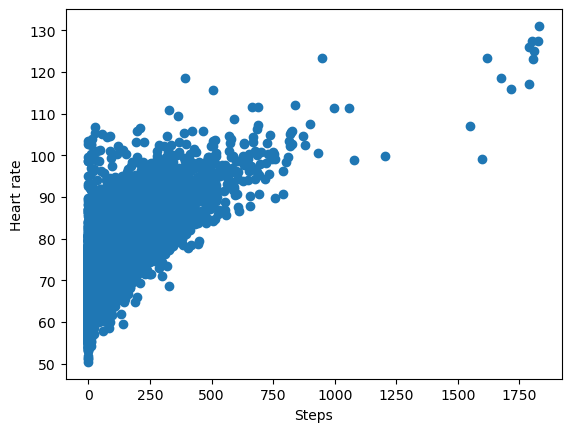

In [6]:
user = 'AFPB8J2'
df, limits = read_files('15min', f'../../../Data/COVID-19-Wearables/{user}')
print(limits)

plt.scatter(df.steps, df.heartrate)
plt.xlabel('Steps')
plt.ylabel('Heart rate')
plt.show()

Descriminator performance on:
	 Real data= {'loss': 0.5975764989852905}
	 Fake data= {'loss': -0.5975760221481323}

Before conversion to real range:
Data limit= [(-1.0, 1.0), (-1.0, 1.0)]
Real data limit= [(-1.0, 1.0), (-1.0, 1.0)]
Data limit= [(-0.9995685, 0.9707237), (-0.9173445, 0.9357498)]
Fake data limit= [(-0.9995685, 0.9707237), (-0.9173445, 0.9357498)]

After conversion to real range:
Data limit= [(0.0, 1831.0), (50.39189, 131.03886)]
Real data limit= [(0.0, 1831.0), (50.39189, 131.03886)]
Data limit= [(0.39501813, 1804.1975), (53.72485, 128.44807)]
Fake data limit= [(0.39501813, 1804.1975), (53.72485, 128.44807)]


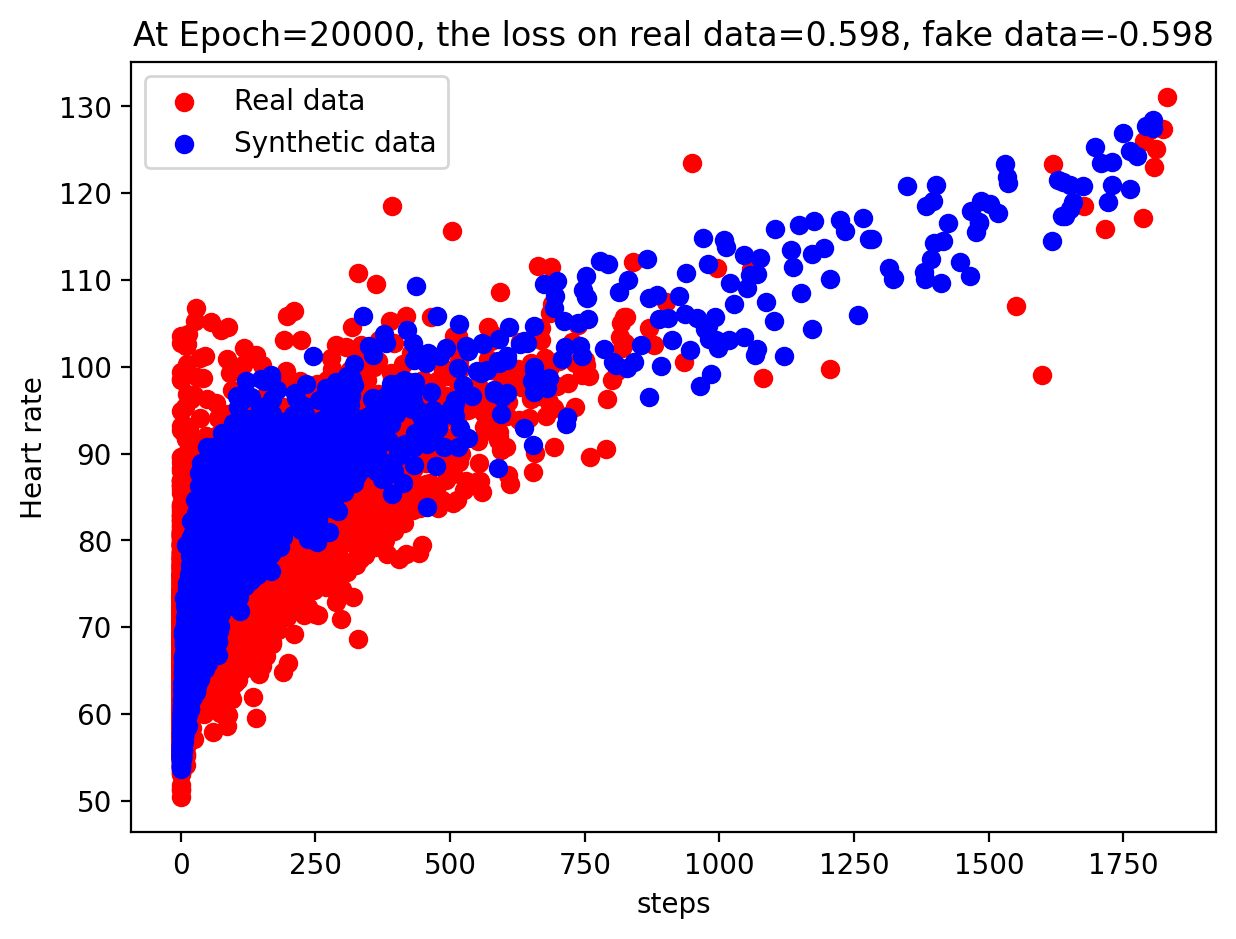

20000 iteration completed.


In [9]:
init = RandomNormal(stddev=0.2, seed=np.random.randint(100, 100000, size=1)[0])
cv = ClipConstraint(0.1)
opt = RMSprop(learning_rate=0.0005)

obj = DataProcessing(df, latent_dim=5, image_path='./img/V2/', model_path='./model/V2/', kernel_init=init, kernel_const=cv, optimizer=opt, dataConversion=(-1,1))
obj.train(n_epochs=20000, n_fold=5, n_eval=20)